## Flow Matching - Dummy Data

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits, make_moons
import matplotlib.pyplot as plt
import torch

In [ ]:
from typing import List, Optional

## Flow Matcing Example Using Checker Board

In [ ]:
def make_checker_board(num_sample:int) -> torch.tensor:
    """
    Returns a Checker Board Pattern of dim (num_sample*16, 2)
    """
    dim = 2
    noise1 = torch.FloatTensor(num_sample, dim).uniform_(0.0, 1.0)
    noise2 = torch.FloatTensor(num_sample, dim).uniform_(1.0, 2.0)
    noise3 = torch.FloatTensor(num_sample, dim).uniform_(2.0, 3.0) - torch.tensor([0.0, 2.0])
    noise4 = torch.FloatTensor(num_sample, dim).uniform_(3.0, 4.0) - torch.tensor([0.0, 2.0])

    first_quad = torch.cat((noise1, noise2), dim=0)
    second_quad = first_quad - torch.tensor([2.0, 0.0])
    third_quad = first_quad * torch.tensor([-1.0, -1.0])
    fourth_quad = first_quad - torch.tensor([0.0, 2.0])

    noise = torch.cat((first_quad, second_quad, third_quad, fourth_quad), dim=0)
    return noise

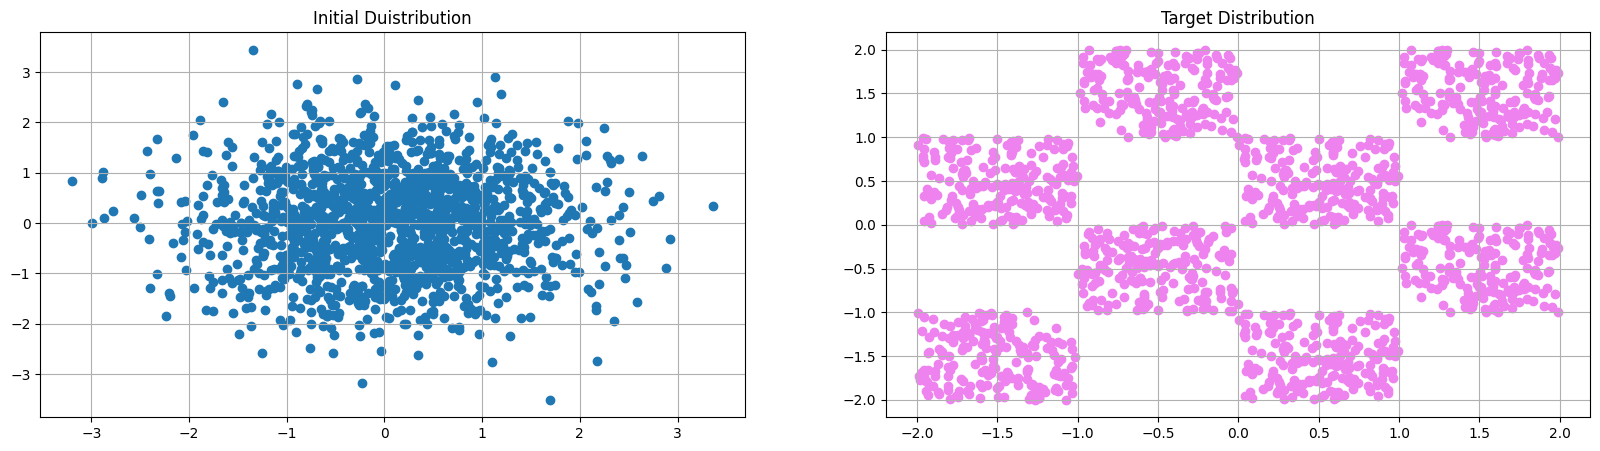

In [ ]:
data_dist = make_checker_board(200)
init_dist = torch.randn_like(data_dist)

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.scatter(init_dist[:, 0], init_dist[:, 1])
plt.title("Initial Duistribution")
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(data_dist[:, 0], data_dist[:, 1], c='violet')
plt.title("Target Distribution")

plt.grid(True)
plt.show()

In [ ]:
init_dist.shape, data_dist.shape

(torch.Size([1600, 2]), torch.Size([1600, 2]))

## Simple Neural Network Model

In [ ]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
class FlowMatchingModel(nn.Module):
    def __init__(self, input_dim:int = 2):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_dim+1, 16), nn.ReLU(),
            nn.Linear(16, 32), nn.ReLU(),
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 512), nn.ReLU(),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )


    def forward(self, x:torch.tensor, t:torch.tensor):
        x = torch.cat((x, t), dim=-1)
        return self.layer(x)

    def step(self, x_t:torch.tensor, t:torch.tensor, dt:torch.tensor):
        time_delta = dt/2
        mid_u_t = self(x_t, t)
        mid_x_t = x_t + mid_u_t * time_delta
        u_t = self(mid_x_t, t+time_delta)
        x_t = mid_x_t + u_t * time_delta
        return x_t

    @torch.no_grad
    def sample(self, x_0:torch.tensor, num_step:int):
        self.prob_paths = []
        self.time = []
        x_t = x_0
        time_steps = torch.linspace(0.0, 1.0, num_step).to(device)
        self.prob_paths.append(x_0.detach().cpu().numpy())
        self.time.append(0.0)

        for i in range(len(time_steps)-1):
            dt = time_steps[i+1] - time_steps[i]
            t = torch.full((x_t.shape[0], 1), time_steps[i]).to(device)
            x_t = self.step(x_t, t, dt)
            self.prob_paths.append(x_t.detach().cpu().numpy())
            self.time.append(time_steps[i+1])
        return x_t

## Training Flow Model

In [ ]:

model = FlowMatchingModel().to(device=device)
Loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
epochs = 3000
for epoch in range(epochs):
    target = make_checker_board(300).to(device)
    noise = torch.randn_like(target)
    t = torch.rand(target.shape[0], 1).to(device)

    xt = ( 1- t) * noise + t * target
    output = model(xt, t)

    loss = Loss(output, target-noise)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    print(f"epoch : {epoch+1}/{epochs}: Loss : {loss.item()}")

# target = torch.tensor(make_moons(1000, noise=0.05, shuffle=True)[0], dtype=torch.float32).to(device)


epoch : 1/3000: Loss : 2.426952600479126
epoch : 2/3000: Loss : 2.377410650253296
epoch : 3/3000: Loss : 2.424210786819458
epoch : 4/3000: Loss : 2.3002851009368896
epoch : 5/3000: Loss : 2.352430820465088
epoch : 6/3000: Loss : 2.3495495319366455
epoch : 7/3000: Loss : 2.369858980178833
epoch : 8/3000: Loss : 2.3303396701812744
epoch : 9/3000: Loss : 2.4111454486846924
epoch : 10/3000: Loss : 2.3917274475097656
epoch : 11/3000: Loss : 2.2977426052093506
epoch : 12/3000: Loss : 2.3767428398132324
epoch : 13/3000: Loss : 2.353421926498413
epoch : 14/3000: Loss : 2.3144421577453613
epoch : 15/3000: Loss : 2.359316110610962
epoch : 16/3000: Loss : 2.353443145751953
epoch : 17/3000: Loss : 2.345355987548828
epoch : 18/3000: Loss : 2.41218638420105
epoch : 19/3000: Loss : 2.32088303565979
epoch : 20/3000: Loss : 2.305769205093384
epoch : 21/3000: Loss : 2.335519313812256
epoch : 22/3000: Loss : 2.323002576828003
epoch : 23/3000: Loss : 2.2755086421966553
epoch : 24/3000: Loss : 2.2191991806

Text(0.5, 1.0, 'Predicted Data Distribution')

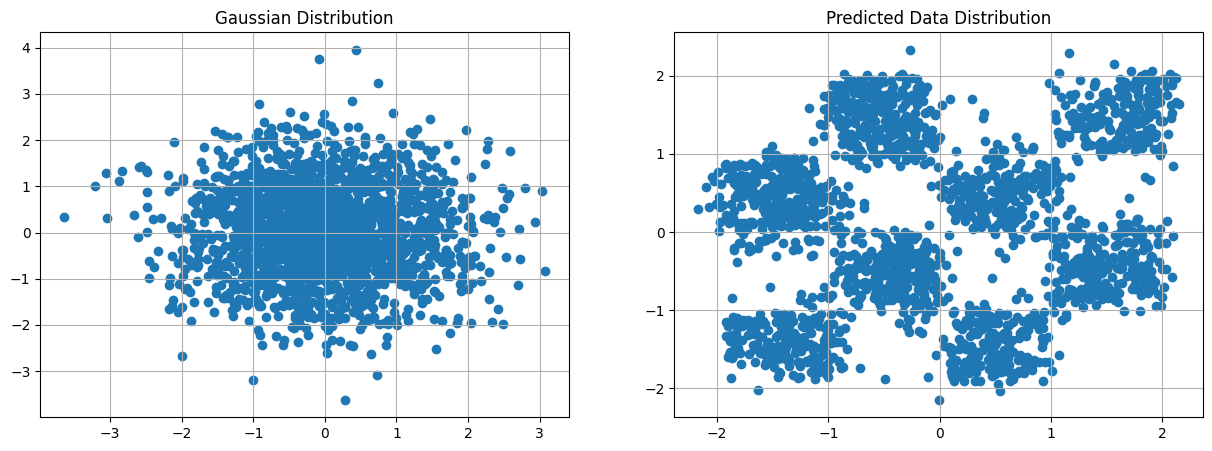

In [ ]:
num_steps = 20
x_0 = torch.randn(2000, 2).to(device)
x_1 = model.sample(x_0, num_steps)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.scatter(x_0[:, 0].detach().cpu().numpy(), x_0[:, 1].detach().cpu().numpy())
plt.grid(True)
plt.title("Gaussian Distribution")

plt.subplot(1,2,2)
plt.scatter(x_1[:, 0].detach().cpu().numpy(), x_1[:, 1].detach().cpu().numpy())
plt.grid(True)
plt.title("Predicted Data Distribution")

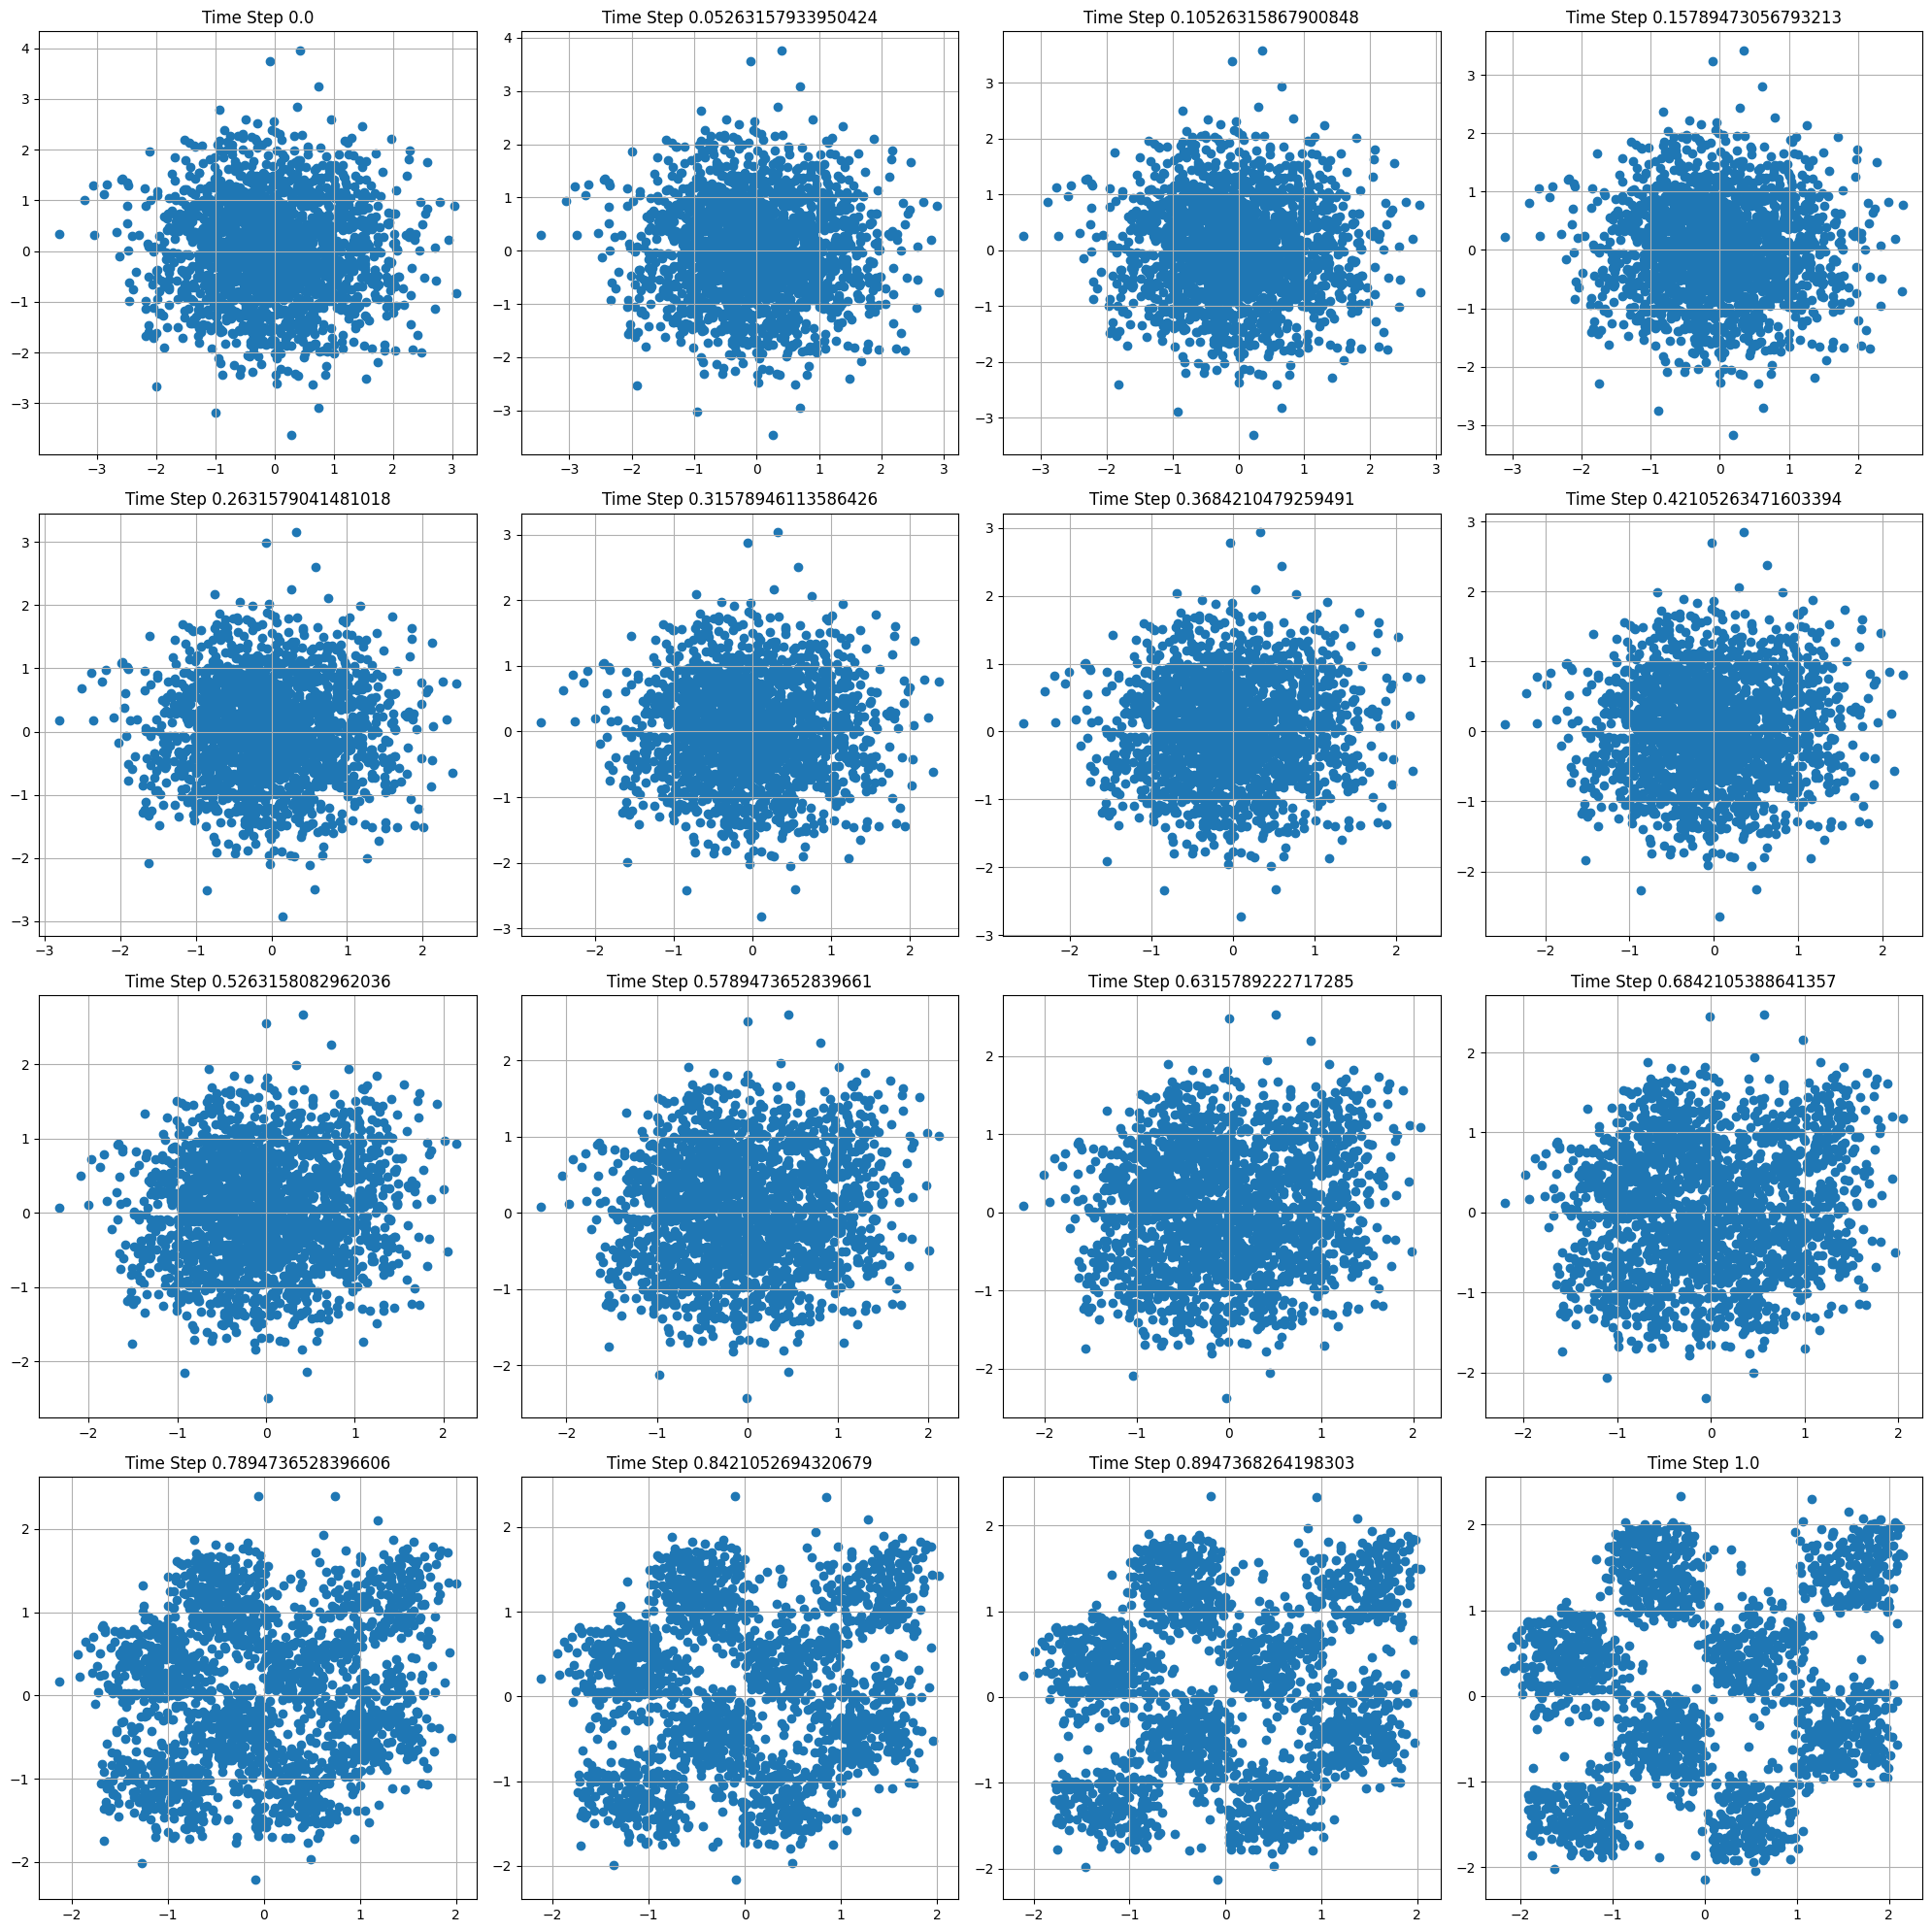

In [ ]:
Row, Col = 4, 4
fig, axes = plt.subplots(Row, Col, figsize=(20, 20))
indexes = torch.linspace(0, num_steps-1, Row*Col, dtype=torch.int32)

for i in range(len(indexes)):
    row = i // Row
    col = i % Col
    index = indexes[i]

    axes[row, col].scatter(model.prob_paths[index][:, 0], model.prob_paths[index][:, 1])
    axes[row, col].grid(True)
    axes[row, col].set_title(f"Time Step {model.time[index]}")

plt.tight_layout()
plt.show()

## Flow Matching - MNIST DATA (Unguided)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [6]:
data = np.load('D:/notebook/deeplearning_crash_course/data/Images(500x500)-001.npy')
label = np.load('D:/notebook/deeplearning_crash_course/data/WriterInfo.npy')
data.shape, label.shape

((13580, 500, 500), (13580, 9))

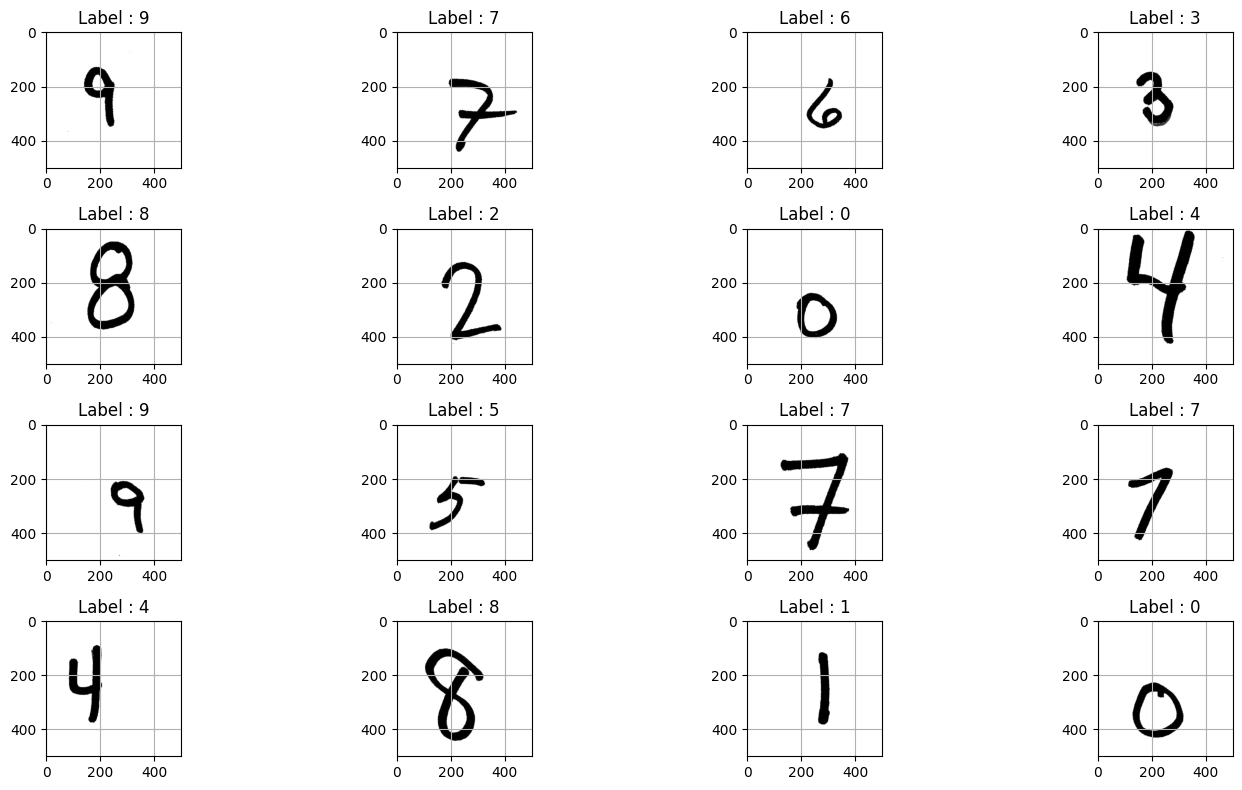

In [7]:
Row, Col = 4, 4
fig, axes = plt.subplots(Row, Col, figsize=(15, 8))

for i in range(Row*Col):
    index = np.random.randint(0, data.shape[0])
    row_idx = i // Col
    col_idx = i % Col

    axes[row_idx, col_idx].imshow(data[index], cmap='gray')
    axes[row_idx, col_idx].set_title(f"Label : {label[index][0]}")
    axes[row_idx, col_idx].grid(True)

plt.tight_layout()
plt.show()

In [16]:
# index = np.random.randint(0, data.shape[0])
# img = cv2.resize(data[index], (256, 256), cv2.INTER_LINEAR)

# plt.subplot(1,2,1)
# plt.imshow(data[index], cmap='gray')
# plt.title("Real Image")

# plt.subplot(1,2,2)
# plt.imshow(img, cmap='gray')
# plt.title("shrinked Image")

image = torch.tensor(data[index]/255.0, dtype=torch.float32)
image.dtype
# label[index][0]

torch.float32

## Data Loader

In [19]:
import cv2
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader

In [34]:
class MNISTData(Dataset):
    def __init__(self, file_path:str, label_path:str):
        super().__init__()

        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File does not exists at : {file_path}")
        if not os.path.exists(label_path):
            raise FileNotFoundError(f"File does not exists at : {label_path}")
        
        self.data = np.load(file_path)
        self.label = np.load(label_path)

    
    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        image = torch.tensor(cv2.resize(self.data[index], (256, 256), cv2.INTER_LINEAR), dtype=torch.float32).unsqueeze(dim=0)
        # label = self.label[index][0]
        noise = torch.randn_like(image)
        t = torch.rand(1)
        x_t = (1 - t) * noise + t * image
        return image, noise, x_t, t

        

**Test Dataset & DataLoader**

In [ ]:
# file_path = 'D:/notebook/deeplearning_crash_course/data/Images(500x500)-001.npy'
# label_path = 'D:/notebook/deeplearning_crash_course/data/WriterInfo.npy'
# train_dataset = MNISTData(file_path, label_path)
# dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
# image, noise, x_t, t = next(iter(dataloader))
# image.shape, noise.shape, x_t.shape, t.shape

(torch.Size([32, 1, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 torch.Size([32, 1, 256, 256]),
 torch.Size([32, 1]))

## Flow Matching Model For MNIST **(Guided & Unguided)**

![Model architecture](../data/model_architecture.png)

In [44]:
import torch
import torch.nn as nn

In [45]:
class EmbeddingLayer(nn.Module):
    def __init__(self, in_dim:int=1, h_dim:int=16):
        super().__init__()
        assert h_dim % 2 == 0, "h_dim must be divided by zero"
        self.in_dim = in_dim
        self.half_dim = h_dim // 2

        self.w = nn.Parameter(torch.rand(1, self.half_dim))
    
    def forward(self, t:torch.tensor):
        """
        Args:
            t: dim(bs, 1) -> dim(bs, time)
        Returns:
            t_embed: dim(bs, h_dim)
        """
        freqs = t @ self.w
        sin_embeds = torch.sin(2 * torch.pi * freqs)
        cos_embeds = torch.cos(2 * torch.pi * freqs)
        embeddings = torch.zeros(t.shape[0], self.half_dim*2, device=t.device)
        embeddings[:, 0::2] = sin_embeds
        embeddings[:, 1::2] = cos_embeds
        return embeddings

In [46]:
class ResidualLayer(nn.Module):
    def __init__(self, channel:int, mlp_dim:int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel),
            nn.SiLU()
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(channel, channel, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel),
            nn.SiLU()
        )
        self.MLP = nn.Sequential(
            nn.Linear(mlp_dim, channel),
            nn.ReLU()
        )

    def forward(self, x:torch.tensor, t:torch.tensor):
        residual = x.clone()
        t = self.MLP(t).unsqueeze(-1).unsqueeze(-1)
        x = self.layer1(x) + t
        x = self.layer2(x) + residual
        return x


In [47]:
class DownSampleLayer(nn.Module):
    def __init__(self, in_channel:int, out_channel:int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

    def forward(self, x:torch.tensor):
        return self.layer(x)
    
class UpSampleLayer(nn.Module):
    def __init__(self, in_channel:int, out_channel:int):
        super().__init__()

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2, padding=0),
            nn.ReLU()
        )

    def forward(self, x:torch.tensor):
        return self.layer(x)

In [48]:
class Encoder(nn.Module):
    def __init__(self, in_channel:int, out_channel:int, mlp_dim:int):
        super().__init__()
        
        self.res_layers = nn.ModuleList([
            ResidualLayer(in_channel, mlp_dim) for _ in range(2)
        ])

        self.down_sample = DownSampleLayer(in_channel, out_channel)

    def forward(self, x:torch.tensor, t:torch.tensor):
        for layer in self.res_layers:
            x = layer(x, t)
        return self.down_sample(x)
    
class Decoder(nn.Module):
    def __init__(self, in_channel:int, out_channel:int, mlp_dim:int):
        super().__init__()

        self.res_layers = nn.ModuleList([
            ResidualLayer(out_channel, mlp_dim) for _ in range(2)
        ])

        self.up_sample = UpSampleLayer(in_channel, out_channel)

    def forward(self, x:torch.tensor, t:torch.tensor):
        x = self.up_sample(x)
        for layer in self.res_layers:
            x = layer(x, t)
        return x
    

class Midcoder(nn.Module):
    def __init__(self, channels:int, mlp_dim:int):
        super().__init__()
        self.layers = nn.ModuleList([
            ResidualLayer(channels, mlp_dim) for _ in range(3)
        ])


    def forward(self, x:torch.tensor, t:torch.tensor):
        for layer in self.layers:
            x = layer(x, t)
        return x

In [41]:
class UnGuidedFlowMatching(nn.Module):
    def __init__(self, in_channel:int, embed_dim:int):
        super().__init__()

        self.channels = [32, 64, 128, 256, 512]
        self.init_conv = nn.Conv2d(in_channel, self.channels[0], kernel_size=3, padding=1)
        self.final_conv = nn.Conv2d(self.channels[0], in_channel, kernel_size=3, padding=1)

        self.embedding = EmbeddingLayer(h_dim=embed_dim)
        self.encoders = nn.ModuleList([
            Encoder(ch1, ch2, embed_dim) for ch1, ch2 in zip(self.channels[:-1], self.channels[1:])
        ])
        self.decoders = nn.ModuleList([
            Decoder(ch1, ch2, embed_dim) for ch1, ch2 in zip(self.channels[::-1][:-1], self.channels[::-1][1:])
        ])
        self.bottle_neck = Midcoder(self.channels[-1], embed_dim)


    def forward(self, x:torch.tensor, t:torch.tensor):
        intermediate_xt = []

        time_embed = self.embedding(t)
        x_t = self.init_conv(x)

        for encoder in self.encoders:
            x_t = encoder(x_t, time_embed)
            intermediate_xt.append(x_t.clone())
        
        x_t = self.bottle_neck(x_t, time_embed)

        for decoder in self.decoders:
            x_t += intermediate_xt.pop()
            x_t = decoder(x_t, time_embed)
        
        u_t = self.final_conv(x_t)
        return u_t
        

In [ ]:
# model = UnGuidedFlowMatching(1, 16)

# B, C, H, W = 10, 1, 256, 256
# dummy_img = torch.rand(B, C, H, W)
# dummy_time = torch.rand(B, 1)
# dummy_img.shape, dummy_time.shape

# model.eval()
# out = model(dummy_img, dummy_time)

(torch.Size([10, 1, 256, 256]), torch.Size([10, 1]))

### **Training Unguided**

In [49]:
from torch.nn import MSELoss

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UnGuidedFlowMatching(1, 16).to(device)

In [52]:
file_path = 'D:/notebook/deeplearning_crash_course/data/Images(500x500)-001.npy'
label_path = 'D:/notebook/deeplearning_crash_course/data/WriterInfo.npy'
train_dataset = MNISTData(file_path, label_path)
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [53]:
critetion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

### **Training Loop**

In [ ]:
epochs = 50
for epoch in epochs:
    loss = 0.0
    for image, noise, x_t, t in dataloader:
        
        image = image.to(device)
        noise = noise.to(device)
        x_t = x_t.to(device)
        t = t.to(device)

        out = model(x_t, t)
        Loss = critetion(out, image - noise)
        loss += Loss.item()

        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()

    print(f"epoch : {epoch+1}/{epochs} | Loss : {loss/len(dataloader)}")
